In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [3]:
name='paddy-disease-classification'
setup_comp(name, install='fastai "timm>=0.6.2.dev0"')

Path('paddy-disease-classification')

In [4]:
import timm
from fastai.vision.all import *
from fastcore.parallel import *

set_seed(42)

In [5]:
from myutils import state_versions

In [6]:
state_versions('fastai', 'fastcore')


Below are the versions of `fastai` and `fastcore` currently running at the time of writing this:
* `fastai` : 2.6.3 
* `fastcore` : 1.4.5 
---

In [7]:
path = Path(name); path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/test_images')]

In [8]:
files = get_image_files(path/'train_images')
files[:5]

(#5) [Path('paddy-disease-classification/train_images/hispa/103939.jpg'),Path('paddy-disease-classification/train_images/hispa/106442.jpg'),Path('paddy-disease-classification/train_images/hispa/105708.jpg'),Path('paddy-disease-classification/train_images/hispa/100789.jpg'),Path('paddy-disease-classification/train_images/hispa/107842.jpg')]

In [9]:
im = PILImage.create(files[0]); im.size

(480, 640)

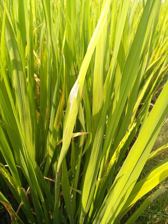

In [10]:
im.to_thumb(224)

In [11]:
def f(i): return PILImage.create(i).size
dims = parallel(f, files, n_workers=8)
pd.Series(dims).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


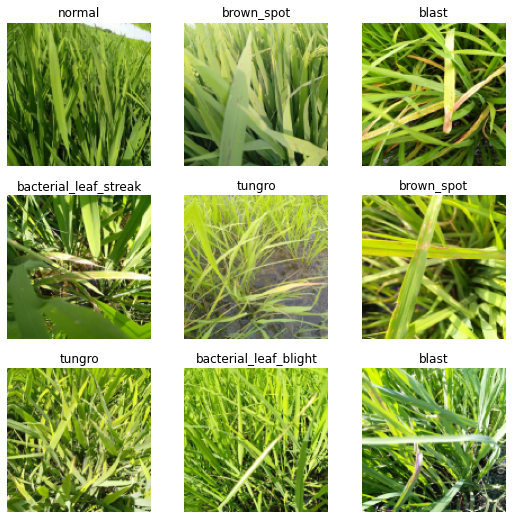

In [12]:
dls = ImageDataLoaders.from_folder(path/'train_images', valid_pct=0.2, seed=42,
                                   item_tfms=Resize(480, method='squish'),
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls.show_batch()

### Our first model

In [13]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0014454397605732083, slide=0.005248074419796467)

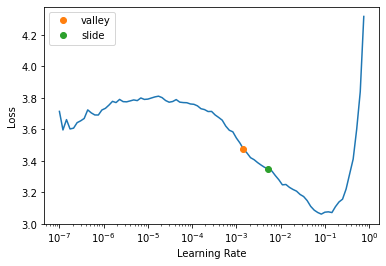

In [14]:
learn.lr_find(suggest_funcs=(valley,slide))

In [15]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.777811,1.204277,0.385392,00:17


epoch,train_loss,valid_loss,error_rate,time
0,1.105431,0.735800,0.252763,00:18
1,0.880068,0.552439,0.189332,00:18
2,0.609226,0.363953,0.120135,00:18
3,0.427325,0.287861,0.098510,00:18
4,0.336344,0.274313,0.088419,00:18


### Testing the model

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


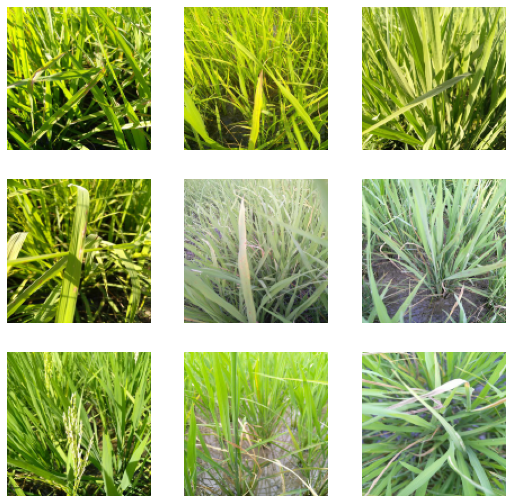

In [16]:
test_files = get_image_files(path/'test_images')
test_dl = dls.test_dl(test_files)
test_dl.show_batch()

In [17]:
probs,_,idxs = learn.get_preds(dl=test_dl, with_decoded=True)

### Making the first Kaggle submission

In [18]:
result = pd.DataFrame({'image_id':[i.name for i in learn.dl.items], 'idx': idxs})
class_lookup = dict(enumerate(dls.vocab))
result['label'] = result['idx'].map(class_lookup)
result.head()

,image_id,idx,label
0,201820.jpg,3,blast
1,202165.jpg,9,tungro
2,200827.jpg,8,normal
3,200237.jpg,4,brown_spot
4,200529.jpg,4,brown_spot


In [19]:
fname='r2-submission-v1.csv'
result.iloc[:,[0,2]].to_csv(fname, index=False)
!head {fname}

image_id,label
201820.jpg,blast
202165.jpg,tungro
200827.jpg,normal
200237.jpg,brown_spot
200529.jpg,brown_spot
203307.jpg,blast
203037.jpg,bacterial_panicle_blight
202974.jpg,blast
200458.jpg,blast


In [20]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli(fname, 'round 2 initial submission', name)

100%|█████████████████████████████████████████████████████████████████████| 70.1k/70.1k [00:01<00:00, 49.6kB/s]


In [23]:
if not iskaggle:
    push_notebook('evangelistatuwe', '01-paddy-getting-started',
                  title='F01 Paddy Getting Started',
                  file='01_paddy-getting-started.ipynb',
                  competition=name, private=False, gpu=True)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/evangelistatuwe/f01-paddy-getting-started
